In [2]:
import os
import sqlite3
import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import graphviz
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Aggregate each game throughout seasons stats
# Train on previous 3 seasons (2020, 2021, 2022)
# Predict last season (2023)
# Predict week 1 of 2024 like its week 19 of 2023

<h1 style="font-size: 36px; color: purple;">Features</h1>

- current w/l record
- current week / number of games played
- last year w/l record
- home game or not
- divison game or not
- current qb ranking
- point differential in current season
    - use as part of elo score?
- win streak?

<h1 style="font-size: 36px; color: purple;">Data Preparation</h1>

In [4]:
!rm -rf data-bak 
!mv data data-bak 
!mkdir data
!cp ../Scrapers/nfl.db data

In [5]:
conn = sqlite3.connect('data/nfl.db')

tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = conn.execute(tables_query).fetchall()
for table in tables:
    table_name = table[0]
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    csv_file_name = f"data/{table_name}.csv"
    df.to_csv(csv_file_name, index=False)
    print(f"Downloaded {table_name} to {csv_file_name}")

conn.close()

Downloaded Teams to data/Teams.csv
Downloaded Games to data/Games.csv
Downloaded PlayerStats to data/PlayerStats.csv
Downloaded Rosters to data/Rosters.csv


In [6]:
# Remove the rows from the 2024 season in Games.csv to UpcomingGames.csv

df = pd.read_csv('data/Games.csv')
upcoming_df = df[df['season'] == 2024]
upcoming_df.to_csv('data/UpcomingGames.csv', index=False)
df_cleaned = df[df['season'] != 2024]
df_cleaned.to_csv('data/Games.csv', index=False)
print("CSV files exported, cleaned Games.csv saved, and UpcomingGames.csv created.")

CSV files exported, cleaned Games.csv saved, and UpcomingGames.csv created.


In [7]:
# Only keep 2019, 2020, 2021, 2022, 2023 seasons
# Remove postseason games

df = pd.read_csv('data/Games.csv')
df = df[df['season'] >= 2019]
df = df[df['game_type'] == 'REG']
df.to_csv('data/Games.csv', index=False)
print("Old seasons removed")

Old seasons removed


In [8]:
# Aggregate current wins/losses/ties per week

df = pd.read_csv('data/Games.csv')

# Initialize columns for "current wins," "current losses," and "current ties"
df['away_current_wins'] = 0
df['away_current_losses'] = 0
df['away_current_ties'] = 0
df['home_current_wins'] = 0
df['home_current_losses'] = 0
df['home_current_ties'] = 0

# Get a list of all teams
teams = pd.concat([df['away_team'], df['home_team']]).unique()

# Iterate over each season and team
for season in df['season'].unique():
    for team in teams:
        # Filter the games for the current team and season, considering both home and away games
        team_games = df[((df['away_team'] == team) | (df['home_team'] == team)) & (df['season'] == season)]
        team_games = team_games.sort_values(by='date')  # Ensure the games are in chronological order
        
        # Initialize win/loss/tie counters
        wins, losses, ties = 0, 0, 0
        
        # Update the cumulative stats game by game
        for idx, game in team_games.iterrows():
            if game['away_team'] == team:  # If the team is playing away
                df.at[idx, 'away_current_wins'] = wins
                df.at[idx, 'away_current_losses'] = losses
                df.at[idx, 'away_current_ties'] = ties
                if game['away_score'] > game['home_score']:
                    wins += 1
                elif game['away_score'] < game['home_score']:
                    losses += 1
                else:
                    ties += 1
            elif game['home_team'] == team:  # If the team is playing at home
                df.at[idx, 'home_current_wins'] = wins
                df.at[idx, 'home_current_losses'] = losses
                df.at[idx, 'home_current_ties'] = ties
                if game['home_score'] > game['away_score']:
                    wins += 1
                elif game['home_score'] < game['away_score']:
                    losses += 1
                else:
                    ties += 1

# Save the updated DataFrame to a new CSV file
df.to_csv('data/Games.csv', index=False)

# Display the Dallas Cowboys' 2023 season rows with updated stats
cowboys_2023_df = df[(df['season'] == 2023) & ((df['away_team'] == 'DAL') | (df['home_team'] == 'DAL'))]
display(cowboys_2023_df[['season', 'week', 'away_team', 'home_team', 'away_current_wins', 'away_current_losses', 'away_current_ties', 'home_current_wins', 'home_current_losses', 'home_current_ties']])

,season,week,away_team,home_team,away_current_wins,away_current_losses,away_current_ties,home_current_wins,home_current_losses,home_current_ties
1069,2023,1,DAL,NYG,0,0,0,0,0,0
1082,2023,2,NYJ,DAL,1,0,0,1,0,0
1098,2023,3,DAL,ARI,2,0,0,0,2,0
1115,2023,4,NE,DAL,1,2,0,2,1,0
1131,2023,5,DAL,SF,3,1,0,4,0,0
1147,2023,6,DAL,LAC,3,2,0,2,2,0
1163,2023,8,LAR,DAL,3,4,0,4,2,0
1188,2023,9,DAL,PHI,5,2,0,7,1,0
1201,2023,10,NYG,DAL,2,7,0,5,3,0
1206,2023,11,DAL,CAR,6,3,0,1,8,0


In [9]:
# Aggregate last season overall wins/losses/ties

df = pd.read_csv('data/Games.csv')

# Initialize columns for last year's wins, losses, and ties
df['away_team_last_year_wins'] = 0
df['away_team_last_year_losses'] = 0
df['away_team_last_year_ties'] = 0
df['home_team_last_year_wins'] = 0
df['home_team_last_year_losses'] = 0
df['home_team_last_year_ties'] = 0

# Calculate the overall wins, losses, and ties for each team by season
team_stats_last_year = {}

for season in df['season'].unique():
    # Filter the games for the previous season
    last_season = season - 1
    season_games = df[df['season'] == last_season]
    
    for team in pd.concat([season_games['away_team'], season_games['home_team']]).unique():
        # Filter the games for the current team
        team_games = season_games[(season_games['away_team'] == team) | (season_games['home_team'] == team)]
        
        # Calculate wins, losses, and ties
        wins = sum((team_games['away_team'] == team) & (team_games['away_score'] > team_games['home_score'])) + \
               sum((team_games['home_team'] == team) & (team_games['home_score'] > team_games['away_score']))
        
        losses = sum((team_games['away_team'] == team) & (team_games['away_score'] < team_games['home_score'])) + \
                 sum((team_games['home_team'] == team) & (team_games['home_score'] < team_games['away_score']))
        
        ties = sum(team_games['away_score'] == team_games['home_score'])
        
        # Store the stats for this team and season
        team_stats_last_year[(team, season)] = {'wins': wins, 'losses': losses, 'ties': ties}

# Assign the last year's stats to the corresponding games
for idx, row in df.iterrows():
    current_season = row['season']
    away_team = row['away_team']
    home_team = row['home_team']
    
    # Set the last year's record for both away and home teams if it exists
    if (away_team, current_season) in team_stats_last_year:
        df.at[idx, 'away_team_last_year_wins'] = team_stats_last_year[(away_team, current_season)]['wins']
        df.at[idx, 'away_team_last_year_losses'] = team_stats_last_year[(away_team, current_season)]['losses']
        df.at[idx, 'away_team_last_year_ties'] = team_stats_last_year[(away_team, current_season)]['ties']
    
    if (home_team, current_season) in team_stats_last_year:
        df.at[idx, 'home_team_last_year_wins'] = team_stats_last_year[(home_team, current_season)]['wins']
        df.at[idx, 'home_team_last_year_losses'] = team_stats_last_year[(home_team, current_season)]['losses']
        df.at[idx, 'home_team_last_year_ties'] = team_stats_last_year[(home_team, current_season)]['ties']

# Now drop 2019 games
df = df[df['season'] >= 2020]

# Calculate win percentages for last season
df['away_team_last_year_win_pct'] = df['away_team_last_year_wins'] / (
    df['away_team_last_year_wins'] + df['away_team_last_year_losses'] + df['away_team_last_year_ties']
)

df['home_team_last_year_win_pct'] = df['home_team_last_year_wins'] / (
    df['home_team_last_year_wins'] + df['home_team_last_year_losses'] + df['home_team_last_year_ties']
)

# Calculate win percentages for current season up to the current game
df['away_team_current_win_pct'] = df['away_current_wins'] / (
    df['away_current_wins'] + df['away_current_losses'] + df['away_current_ties']
)

df['home_team_current_win_pct'] = df['home_current_wins'] / (
    df['home_current_wins'] + df['home_current_losses'] + df['home_current_ties']
)

# Remove all tied games
# df = df[df['home_score'] != df['away_score']]

df.to_csv('data/Games.csv')
print("Data saved back to Games.csv")

# Verify
df = pd.read_csv('data/Games.csv')
cowboys_df = df[(df['away_team'] == 'DAL')]
cowboys_df = cowboys_df.sort_values(by=['season', 'date'])
unique_last_season_stats = cowboys_df[['season', 'away_team', 'away_team_last_year_wins', 'away_team_last_year_losses', 
                                       'away_team_last_year_win_pct']].drop_duplicates()
display(unique_last_season_stats)

Data saved back to Games.csv


,season,away_team,away_team_last_year_wins,away_team_last_year_losses,away_team_last_year_win_pct
13,2020,DAL,8,8,0.500000
256,2021,DAL,6,10,0.375000
575,2022,DAL,12,5,0.705882
813,2023,DAL,12,5,0.705882


In [8]:
# # Calculate the number of games played so far in the current season

# # df['away_team_games_played'] = df['away_current_wins'] + df['away_current_losses'] + df['away_current_ties']
# # df['home_team_games_played'] = df['home_current_wins'] + df['home_current_losses'] + df['home_current_ties']

In [10]:
# Create division game flag

games_df = pd.read_csv('data/Games.csv')

# Define the division mapping for all NFL teams
division_mapping = {
    'ARI': 'NFC West', 'LAR': 'NFC West', 'SEA': 'NFC West', 'SF': 'NFC West',
    'ATL': 'NFC South', 'CAR': 'NFC South', 'NO': 'NFC South', 'TB': 'NFC South',
    'CHI': 'NFC North', 'DET': 'NFC North', 'GB': 'NFC North', 'MIN': 'NFC North',
    'DAL': 'NFC East', 'NYG': 'NFC East', 'PHI': 'NFC East', 'WAS': 'NFC East',
    'BUF': 'AFC East', 'MIA': 'AFC East', 'NE': 'AFC East', 'NYJ': 'AFC East',
    'BAL': 'AFC North', 'CIN': 'AFC North', 'CLE': 'AFC North', 'PIT': 'AFC North',
    'HOU': 'AFC South', 'IND': 'AFC South', 'JAX': 'AFC South', 'TEN': 'AFC South',
    'DEN': 'AFC West', 'KC': 'AFC West', 'LAC': 'AFC West', 'LVR': 'AFC West'
}

# Map teams to their respective divisions
games_df['home_division'] = games_df['home_team'].map(division_mapping)
games_df['away_division'] = games_df['away_team'].map(division_mapping)

# Determine if a game is a division game
games_df['division_game'] = (games_df['home_division'] == games_df['away_division']).astype(int)

# Drop the temporary division columns
games_df.drop(columns=['home_division', 'away_division'], inplace=True)

# Save the updated dataframe to a new CSV file if needed
games_df.to_csv('data/Games.csv', index=False)

# Optional: Display the first few rows to verify
display(games_df[['home_team', 'away_team', 'division_game']].head())

,home_team,away_team,division_game
0,KC,HOU,0
1,ATL,SEA,0
2,BAL,CLE,1
3,BUF,NYJ,1
4,CAR,LVR,0


In [ ]:
!open data/Games.csv

<h1 style="font-size: 36px; color: purple;">Models</h1>

# Logistic Regression

X: features = ['spread_line', 'away_current_wins', 'away_current_losses', 'home_current_wins', 'home_current_losses']

y: 'home_win' 

***Try something else like favorite_team wins?***

***Take absolute value of spread_line and add favorite column?***

***Scale features?***

***Remove 1st/2nd weeks games?***

training seasons >> [2020 2021 2022]
test season >> [2023]

Accuracy: 68.38%

R-squared (Training Set): 0.6616352201257861
R-squared (Test Set): 0.6838235294117647

Confusion Matrix:
[[ 73  48]
 [ 38 113]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.60      0.63       121
           1       0.70      0.75      0.72       151

    accuracy                           0.68       272
   macro avg       0.68      0.68      0.68       272
weighted avg       0.68      0.68      0.68       272


Coefficients:
away_current_losses           -0.268676
away_current_wins             -0.215731
home_team_current_win_pct     -0.058368
away_team_last_year_win_pct   -0.005210
away_team_current_win_pct      0.016093
away_rest                      0.040312
division_game                  0.064220
home_rest                      0.075751
home_team_last_year_win_pct    0.081393
week                           0.131864
home_current_wins           

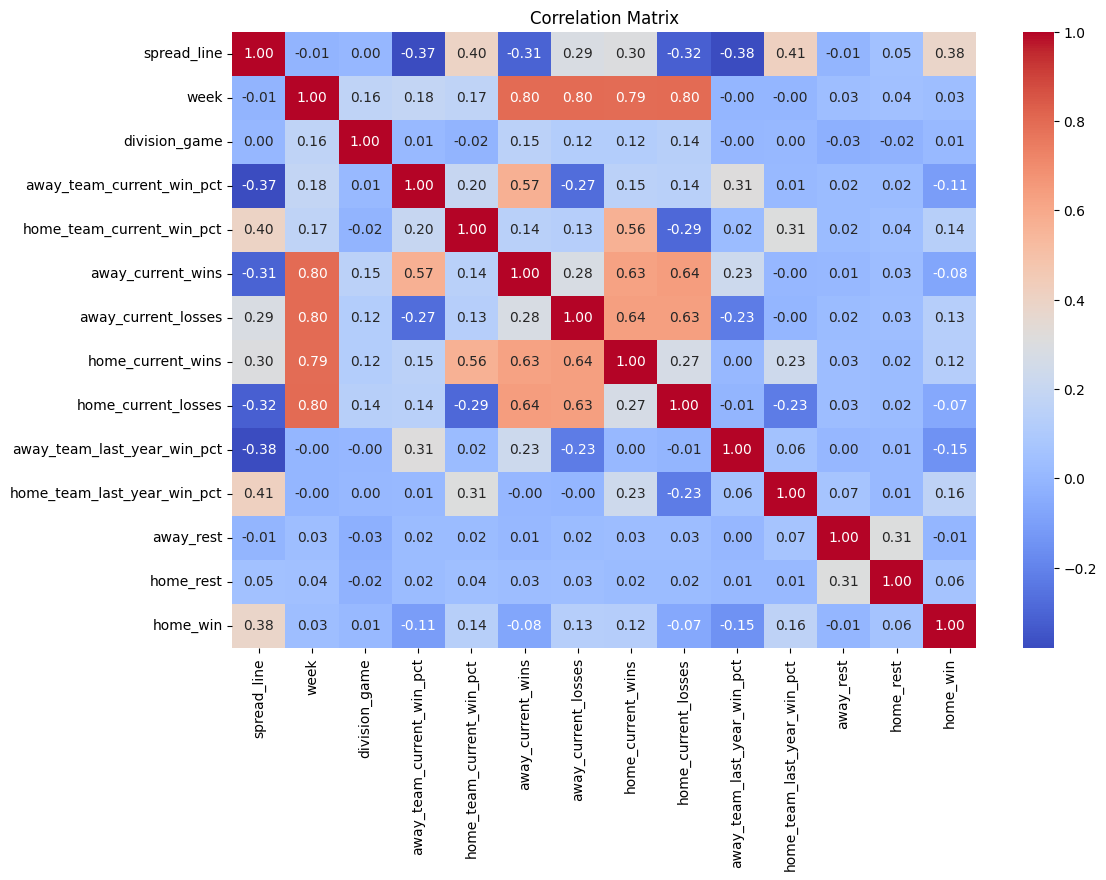

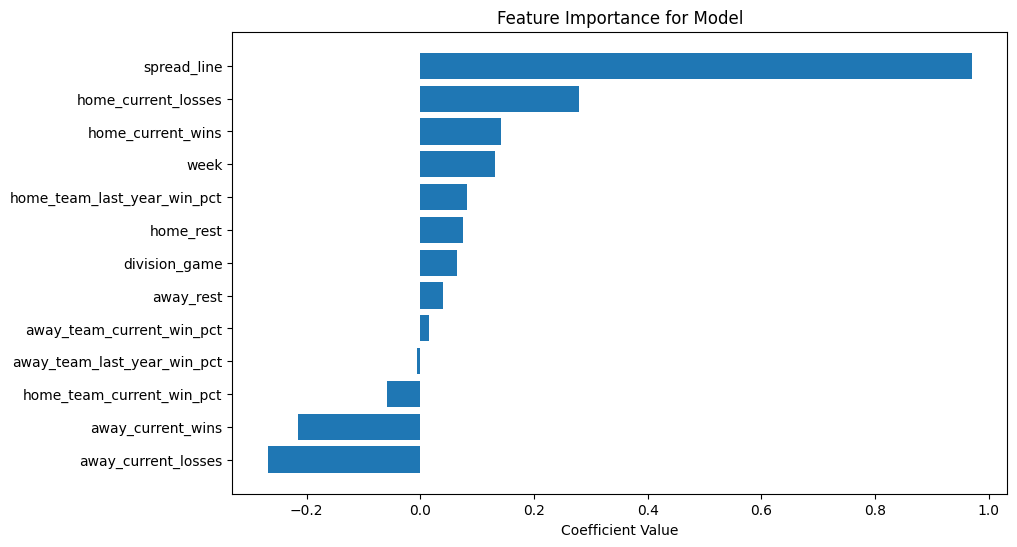

In [12]:
# Predict home team winning
# Training on 2020, 2021, 2022
# Predicting 2023

df  = pd.read_csv('data/Games.csv')

# Remove all tied games
df = df[df['home_score'] != df['away_score']]

# Fill week 1 games
df['away_team_current_win_pct'] = df['away_team_current_win_pct'].fillna(0)
df['home_team_current_win_pct'] = df['home_team_current_win_pct'].fillna(0)

# Prepare the target variable: 1 if home_team wins, 0 if away_team wins
df['home_win'] = (df['home_score'] > df['away_score']).astype(int)

# Select features for the model
# features = [
#     'spread_line', 'week', 'division_game',
#     'away_team_current_win_pct', 'home_team_current_win_pct',
#     'away_team_last_year_win_pct', 'home_team_last_year_win_pct',
#     'away_rest', 'home_rest'
# ]
features = [
    'spread_line', 'week', 'division_game',
    'away_team_current_win_pct', 'home_team_current_win_pct',
    'away_current_wins', 'away_current_losses',
    'home_current_wins', 'home_current_losses',
    'away_team_last_year_win_pct', 'home_team_last_year_win_pct',
    'away_rest', 'home_rest'
]

# Remove week 1 games
# df = df[df['week'] != 1]

# Drop rows with missing values in the selected features
# df = df.dropna(subset=features)

# Keep only the columns needed plus any additional columns used in processing
columns_to_keep = features + ['home_team', 'away_team', 'home_win', 'home_score', 'away_score', 'season']
df = df[columns_to_keep]

# Split the data into training (2020-2022) and testing (2023)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_df = df[df['season'].isin([2020, 2021, 2022])]
test_df = df[df['season'] == 2023]
X_train = train_df[features]
y_train = train_df['home_win']
X_test = test_df[features]
y_test = test_df['home_win']
print("training seasons >>", train_df['season'].unique())
print("test season >>", test_df['season'].unique())

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the logistic regression model
# model = LogisticRegression()
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the 2023 test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
coefficients = pd.Series(model.coef_[0], index=features)
coefficients = coefficients.sort_values()
intercept = model.intercept_
r_squared_train = model.score(X_train, y_train)
r_squared_test = model.score(X_test, y_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
correlations = df[features + ['home_win']].corr()
print("\nAccuracy: {:.2f}%\n".format(accuracy * 100))
print(f'R-squared (Training Set): {r_squared_train}')
print(f'R-squared (Test Set): {r_squared_test}')
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)
print("\nCoefficients:")
print(coefficients, "\n")
print(f'Intercept: {intercept}\n')

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(coefficients.index, coefficients.values)
plt.xlabel('Coefficient Value')
plt.title('Feature Importance for Model')
plt.show()

In [13]:
# Get predicted probabilities for the positive class (home team win)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Ensure test_df is a copy to avoid SettingWithCopyWarning
test_df = test_df.copy()

# Add the predicted probabilities to the test DataFrame
test_df['predict_proba'] = y_pred_proba

# Display the top predictions sorted by confidence
dispCols = ['home_team', 'away_team', 'spread_line', 'predict_proba']
display(test_df[dispCols].sort_values('predict_proba', ascending=False))
test_df.to_csv('data/test_df_results.csv')

,home_team,away_team,spread_line,predict_proba
945,DAL,NYG,17.5,0.921889
1042,BUF,NE,15.0,0.911153
1001,SF,SEA,14.5,0.899304
860,SF,ARI,15.0,0.896424
890,BUF,NYG,15.5,0.894103
1037,PHI,NYG,14.0,0.889988
956,MIA,LVR,14.0,0.885241
958,SF,TB,13.5,0.866832
1005,MIA,TEN,14.0,0.862420
1036,KC,LVR,11.0,0.861351


In [ ]:
!open data/test_df_results.csv

# XGBoost

- Try both 'booster': 'gbtree' and 'booster': 'gblinear'

[0]	train-logloss:0.66059	eval-logloss:0.68178
[1]	train-logloss:0.63526	eval-logloss:0.67634
[2]	train-logloss:0.61451	eval-logloss:0.67222
[3]	train-logloss:0.59631	eval-logloss:0.66727
[4]	train-logloss:0.58043	eval-logloss:0.66848
[5]	train-logloss:0.56785	eval-logloss:0.66817
[6]	train-logloss:0.55204	eval-logloss:0.67112
[7]	train-logloss:0.54189	eval-logloss:0.67089
[8]	train-logloss:0.52835	eval-logloss:0.67158
[9]	train-logloss:0.51808	eval-logloss:0.67210
[10]	train-logloss:0.50995	eval-logloss:0.67385
[11]	train-logloss:0.50099	eval-logloss:0.67536
[12]	train-logloss:0.49389	eval-logloss:0.67780
[13]	train-logloss:0.48569	eval-logloss:0.67952
Accuracy: 0.5515
Precision: 0.6074
Recall: 0.5430
F1-Score: 0.5734

Confusion Matrix:
[[68 53]
 [69 82]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.56      0.53       121
           1       0.61      0.54      0.57       151

    accuracy                           0.55  

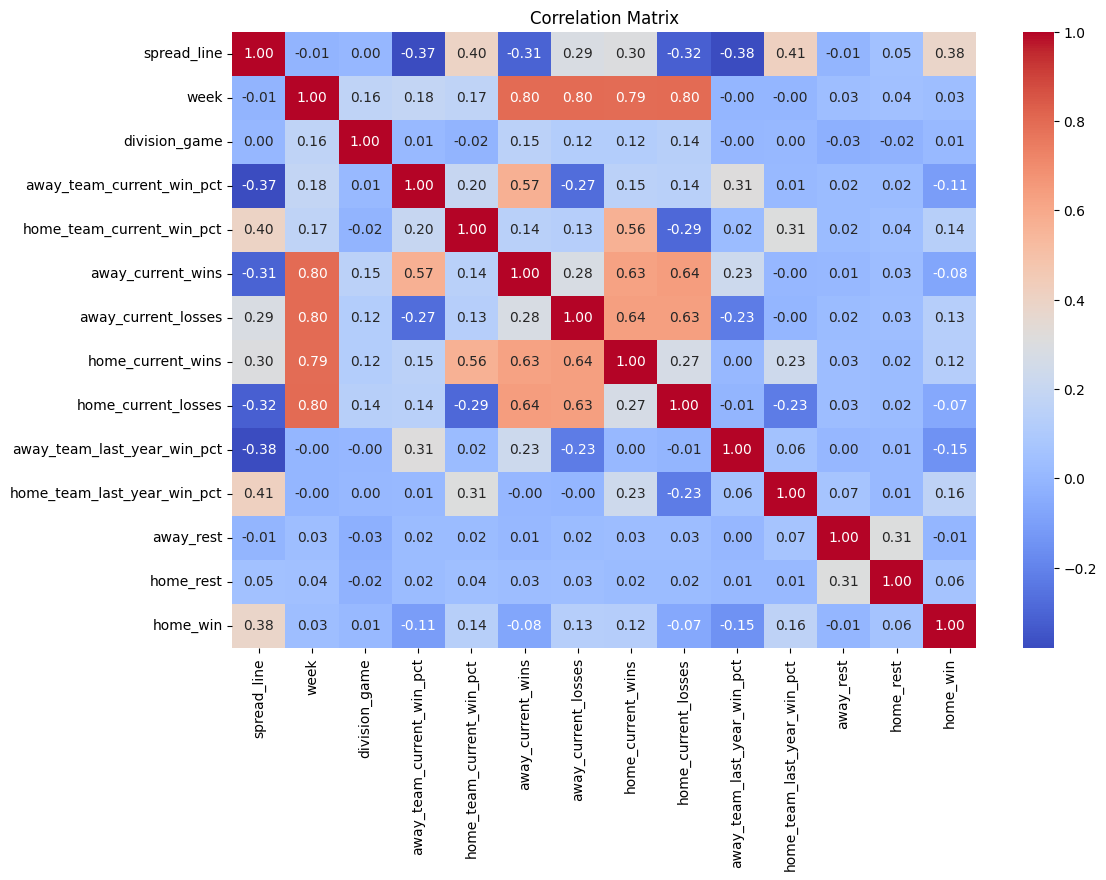

<Figure size 1000x800 with 0 Axes>

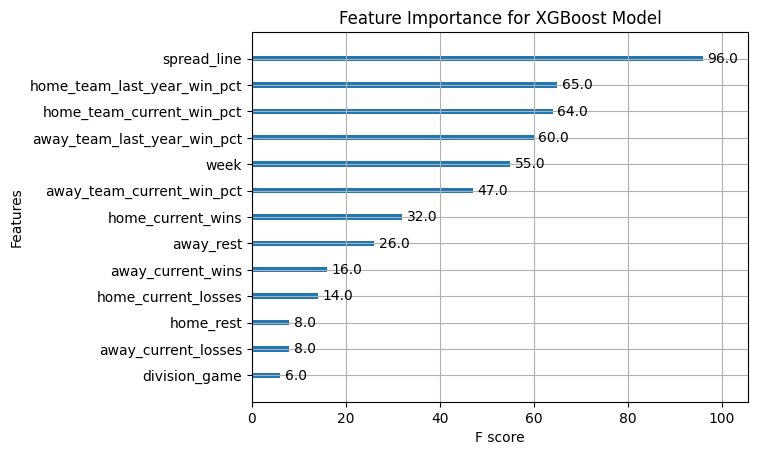

In [27]:
df = pd.read_csv('data/Games.csv')

# Remove tied games
df = df[df['home_score'] != df['away_score']]

# Fill missing values
df['away_team_current_win_pct'] = df['away_team_current_win_pct'].fillna(0)
df['home_team_current_win_pct'] = df['home_team_current_win_pct'].fillna(0)

# Prepare target variable
df['home_win'] = (df['home_score'] > df['away_score']).astype(int)

# Select features
features = [
    'spread_line', 'week', 'division_game',
    'away_team_current_win_pct', 'home_team_current_win_pct',
    'away_current_wins', 'away_current_losses',
    'home_current_wins', 'home_current_losses',
    'away_team_last_year_win_pct', 'home_team_last_year_win_pct',
    'away_rest', 'home_rest'
]

# Keep necessary columns
columns_to_keep = features + ['home_team', 'away_team', 'home_win', 'home_score', 'away_score', 'season']
df = df[columns_to_keep]

# Split the data into training and testing sets
train_df = df[df['season'].isin([2020, 2021, 2022])]
test_df = df[df['season'] == 2023]
X_train = train_df[features]
y_train = train_df['home_win']
X_test = test_df[features]
y_test = test_df['home_win']

# Initialize the scaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters
params = {
    'verbosity': 0,
    'objective': 'binary:logistic',
    # 'booster': 'gblinear',
    'booster': 'gbtree',
    # 'eval_metric': 'logloss',
    'learning_rate': 0.1
}

# Define evaluation set
evallist = [(dtrain, 'train'), (dtest, 'eval')]

# Train the XGBoost model
num_round = 1000
bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=10)
# bst = xgb.train(params, dtrain, num_round, evallist)

# Predict on the test set
ypred = bst.predict(dtest)
# print(ypred)

# Convert predictions to a binary outcome (0 or 1) if using 'binary:logistic'
# Alternatively, if using 'binary:hinge', predictions are already binary
# ypred_binary = ypred
ypred_binary = (ypred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, ypred_binary)
precision = precision_score(y_test, ypred_binary) # Calculate precision
recall = recall_score(y_test, ypred_binary) # Calculate recall
f1 = f1_score(y_test, ypred_binary)
conf_matrix = confusion_matrix(y_test, ypred_binary)
class_report = classification_report(y_test, ypred_binary)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Plot correlation matrix
correlations = df[features + ['home_win']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(bst, importance_type='weight')
plt.title('Feature Importance for XGBoost Model')
plt.show()

In [28]:
# Analyze results

# Save to csv
results_df = test_df[['home_team', 'away_team', 'spread_line']].copy()
results_df['predicted_home_win'] = ypred
results_df.to_csv('data/xgboost_results.csv', index=False)
print("Predicted Probabilities saved to xgboost_results.csv")

# Highest and lowest predictions
df = pd.read_csv('data/xgboost_results.csv')
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows (be cautious with large dataframes)
pd.set_option('display.max_colwidth', None) # Show full column width
df_sorted = df[['home_team', 'away_team', 'spread_line', 'predicted_home_win']].sort_values('predicted_home_win', ascending=False)
# display(df_sorted)
print("Top 20 Highest Predictions:")
display(df_sorted.head(20))
print("\nBottom 20 Lowest Predictions:")
display(df_sorted.tail(20))

Predicted Probabilities saved to xgboost_results.csv
Top 20 Highest Predictions:


,home_team,away_team,spread_line,predicted_home_win
238,PHI,NYG,14.0,0.857556
243,BUF,NE,15.0,0.857556
44,KC,CHI,13.0,0.856618
91,BUF,NYG,15.5,0.856618
126,CLE,ARI,13.0,0.852965
165,DAL,WAS,13.0,0.847293
130,NO,CHI,9.0,0.843787
249,PHI,ARI,12.0,0.843401
159,SF,TB,13.5,0.839353
180,DAL,SEA,9.5,0.836372



Bottom 20 Lowest Predictions:


,home_team,away_team,spread_line,predicted_home_win
216,NE,KC,-10.0,0.266322
166,SEA,SF,-7.0,0.243613
115,WAS,PHI,-7.0,0.214279
105,MIN,SF,-7.0,0.213590
248,NYG,LAR,-6.0,0.171641
172,NYG,NE,-4.5,0.171641
226,LAC,BUF,-13.0,0.167954
79,TEN,BAL,-5.5,0.152062
118,DEN,KC,-7.0,0.152062
83,CLE,SF,-9.5,0.152062


In [ ]:
# Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)
# print("\nAccuracy: {:.2f}%\n".format(accuracy * 100))
# print("\nConfusion Matrix:")
# print(conf_matrix)
# print("\nClassification Report:")
# print(report)


# Ensure test_df is a copy to avoid SettingWithCopyWarning
# test_df = test_df.copy()

# print("Predicted Probabilities:")
# print(ypred)

# # Plot feature importance
# plt.figure(figsize=(10, 6))
# xgb.plot_importance(bst, importance_type='weight')
# plt.title('Feature Importance for XGBoost Model')
# plt.show()

# Plot importance
plt.figure(figsize=(14, 10))  # Set the figure size to make the plot larger
xgb.plot_importance(bst, importance_type='weight', max_num_features=20)  # You can adjust the parameters as needed
plt.title('Feature Importance for XGBoost Model')
plt.show()

In [ ]:
# Analyze results

df = pd.read_csv('data/xgboost_results.csv')
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows (be cautious with large dataframes)
pd.set_option('display.max_colwidth', None) # Show full column width
df_sorted = df[['home_team', 'away_team', 'spread_line', 'predicted_prob']].sort_values('predicted_prob', ascending=False)
display(df_sorted)

In [ ]:
# 3. Try a Different Solver
# Logistic Regression supports different solvers. The default is lbfgs, but you can try saga, newton-cg, or liblinear:
# # Create a Logistic Regression model with a different solver
# model = LogisticRegression(solver='saga', max_iter=1000)
# model.fit(X_train_scaled, y_train)

In [ ]:
# Predict one week of current season
# iweek = 9

# Pick only this week's games for prediction
# dfTest = dfGamesTest[dfGamesTest.gameWeek == iweek]

In [1]:
!cp ../Analysis/data/Games.csv data/

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier

# Load the dataset
file_path = 'data/Games.csv'  # Make sure this path is correct for your local system
data = pd.read_csv(file_path)

# Selecting relevant features for simplicity
features = [
    'away_score', 'home_score', 'spread_line', 'total_line',
    'away_rest', 'home_rest', 'temp', 'wind', 'miles_traveled'
]
target = 'result'  # We'll predict whether the home team won (result > 0)

# Clean up the data by dropping rows with missing values in the relevant columns
data_cleaned = data[features + [target]].dropna()

# Define the feature matrix (X) and target vector (y)
X = data_cleaned[features]
y = (data_cleaned[target] > 0).astype(int)  # 1 if home team won, 0 otherwise

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier with reduced complexity for faster training
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=50, max_depth=3)

# Train the model
model.fit(X_train, y_train)

# Predict the results for the test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (home team wins)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")


Accuracy: 0.99
ROC-AUC Score: 1.00


/Users/tylerdurette/.pyenv/versions/3.12.0/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:21:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [3]:
import pandas as pd

# Create the upcoming games data with 0's for all the features
upcoming_games_data = {
    'game_id': [
        "2024_02_BUF_MIA", "2024_02_LV_BAL", "2024_02_LAC_CAR", "2024_02_NO_DAL", "2024_02_TB_DET", 
        "2024_02_IND_GB", "2024_02_CLE_JAX", "2024_02_SF_MIN", "2024_02_SEA_NE", "2024_02_NYJ_TEN", 
        "2024_02_NYG_WAS", "2024_02_LA_ARI", "2024_02_PIT_DEN", "2024_02_CIN_KC", "2024_02_CHI_HOU", 
        "2024_02_ATL_PHI"
    ],
    'away_score': [0] * 16,  # Set all to 0
    'home_score': [0] * 16,  # Set all to 0
    'spread_line': [0] * 16,  # Set all to 0
    'total_line': [0] * 16,  # Set all to 0
    'away_rest': [0] * 16,  # Set all to 0
    'home_rest': [0] * 16,  # Set all to 0
    'temp': [0] * 16,  # Set all to 0
    'wind': [0] * 16,  # Set all to 0
    'miles_traveled': [0] * 16  # Set all to 0
}

# Convert to DataFrame
upcoming_games_df = pd.DataFrame(upcoming_games_data)

# Ensure that the columns match the training features
features = ['away_score', 'home_score', 'spread_line', 'total_line', 'away_rest', 'home_rest', 'temp', 'wind', 'miles_traveled']

# Make predictions on the upcoming games with zeroed features
predictions = model.predict(upcoming_games_df[features])
probabilities = model.predict_proba(upcoming_games_df[features])[:, 1]  # Get probabilities for the home team winning

# Add predictions and probabilities to the DataFrame
upcoming_games_df['home_team_win_prediction'] = predictions
upcoming_games_df['home_team_win_probability'] = probabilities

# Output the predictions
print(upcoming_games_df[['game_id', 'home_team_win_prediction', 'home_team_win_probability']])


            game_id  home_team_win_prediction  home_team_win_probability
0   2024_02_BUF_MIA                         0                   0.290282
1    2024_02_LV_BAL                         0                   0.290282
2   2024_02_LAC_CAR                         0                   0.290282
3    2024_02_NO_DAL                         0                   0.290282
4    2024_02_TB_DET                         0                   0.290282
5    2024_02_IND_GB                         0                   0.290282
6   2024_02_CLE_JAX                         0                   0.290282
7    2024_02_SF_MIN                         0                   0.290282
8    2024_02_SEA_NE                         0                   0.290282
9   2024_02_NYJ_TEN                         0                   0.290282
10  2024_02_NYG_WAS                         0                   0.290282
11   2024_02_LA_ARI                         0                   0.290282
12  2024_02_PIT_DEN                         0      